<a href="https://colab.research.google.com/github/shivangi-gupta-01/Potato-Disease-Prediction/blob/main/Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [69]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [70]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    # seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2163 files belonging to 3 classes.


In [71]:
classes= dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [72]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 0 1 0 1 0 1 2 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1]


In [73]:
len(dataset)

68

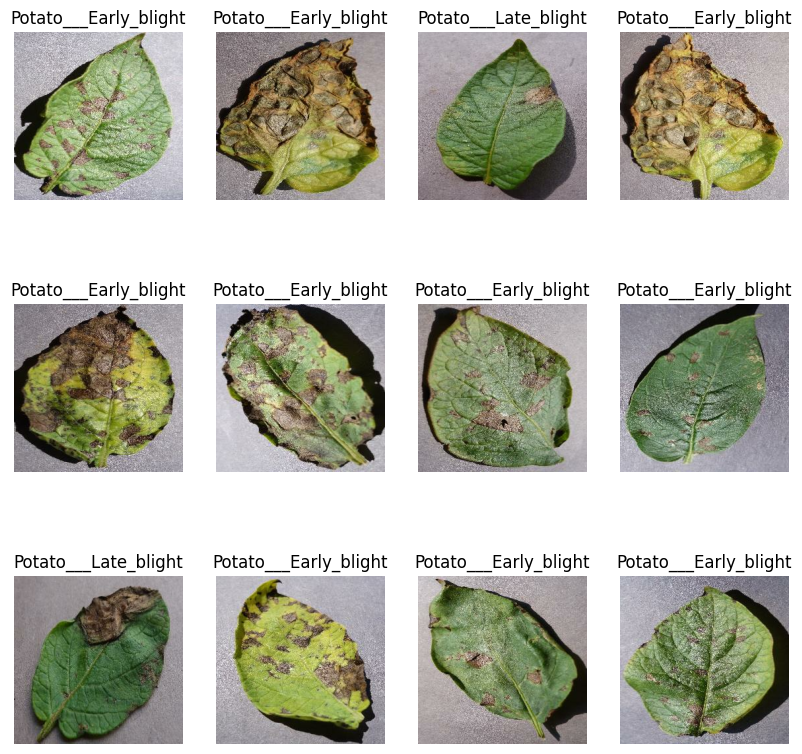

In [65]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range (12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")


In [74]:
len(dataset)

68

In [75]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [76]:
train_ds=dataset.take(54)
len(train_ds)

54

In [77]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [78]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [79]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [80]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [81]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [82]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [83]:
len(train_ds)

54

In [84]:
len(val_ds)

6

In [85]:
len(test_ds)

8

In [86]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [87]:
resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [88]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [89]:
input_shape= (BATCH_SIZE ,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_class=3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation ="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, activation ="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])

model.build(input_shape=input_shape)

In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [91]:
model.compile(
     optimizer='adam',
     loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
     metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 131s 2s/step - loss: 0.6332 - accuracy: 0.7261 - val_loss: 0.4792 - val_accuracy: 0.8125
Epoch 2/50
54/54 [==============================] - 132s 2s/step - loss: 0.3825 - accuracy: 0.8386 - val_loss: 0.3604 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 132s 2s/step - loss: 0.3150 - accuracy: 0.8805 - val_loss: 0.2494 - val_accuracy: 0.9167
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.2520 - accuracy: 0.8969 - val_loss: 0.2043 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 131s 2s/step - loss: 0.2374 - accuracy: 0.9108 - val_loss: 0.4139 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 131s 2s/step - loss: 0.1844 - accuracy: 0.9347 - val_loss: 0.1873 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 131s 2s/step - loss: 0.1905 - accuracy: 0.9254 - val_loss: 0.1653 - val_accuracy: 0.9323
Epoch 8/50
54